In [1]:

import pandas as pd
import numpy as np
import spacy
from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline  

In [2]:
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [3]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
from keras.metrics import Precision, Recall

In [4]:
df = pd.read_csv("financial_sentiment_data.csv")
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5831,RISING costs have forced packaging producer Hu...,negative
5832,Nordic Walking was first used as a summer trai...,neutral
5833,"According shipping company Viking Line , the E...",neutral
5834,"In the building and home improvement trade , s...",neutral


In [5]:
def convert_target(targets):
    sent = {'positive': 1, 'neutral': 0 , 'negative': -1}
    return df.Sentiment.map(sent) 
df.Sentiment=convert_target(df.Sentiment) 

In [6]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",-1
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0
...,...,...
5831,RISING costs have forced packaging producer Hu...,-1
5832,Nordic Walking was first used as a summer trai...,0
5833,"According shipping company Viking Line , the E...",0
5834,"In the building and home improvement trade , s...",0


In [7]:
df=df.drop_duplicates(keep='first') 

In [8]:
df['Sentiment'].value_counts()

 0    3124
 1    1852
-1     860
Name: Sentiment, dtype: int64

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
def cleaning(df, stop_words):
    df['Sentence'] = df['Sentence'].apply(lambda x:' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['Sentence'] = df['Sentence'].str.replace('d', '')
    # Removing stop words
    df['Sentence'] = df['Sentence'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['Sentence'] = df['Sentence'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')
data = cleaning(df, stop_words)
data.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon 's gp...,1
1,"$esi lows, $1.50 $2.50 bk real possibility",-1
2,"last quarter 2010 , componenta 's net sale oub...",1
3,"accoring finnish-russian chamber commerce , ma...",0
4,sweish buyout firm sol remaining 22.4 percent ...,0


In [11]:
# Encoded the target column
lb=LabelEncoder()
data['Sentiment'] = lb.fit_transform(data['Sentiment'])
data.head()

,Sentence,Sentiment
0,geosolutions technology leverage benefon 's gp...,2
1,"$esi lows, $1.50 $2.50 bk real possibility",0
2,"last quarter 2010 , componenta 's net sale oub...",2
3,"accoring finnish-russian chamber commerce , ma...",1
4,sweish buyout firm sol remaining 22.4 percent ...,1


In [12]:
!pip install Keras-Preprocessing

In [13]:
from keras_preprocessing.sequence import pad_sequences

In [14]:
import pickle

In [16]:
# tokenize input text
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data['Sentence'].values)
X = tokenizer.texts_to_sequences(data['Sentence'].values)
X = pad_sequences(X) 

In [17]:
# saving tokenizer
with open('tokenizer_LSTM.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# create model architecture
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 120)           60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 51, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# Splitting the data into training and testing
y = pd.get_dummies(data['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [20]:
# run model 
batch_size=32
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 5, batch_size = batch_size, 
                    verbose = 'auto')

Epoch 1/5
128/128 [==============================] - 120s 764ms/step - loss: 0.9494 - accuracy: 0.5469 - precision: 0.6176 - recall: 0.3111 - val_loss: 0.8444 - val_accuracy: 0.6191 - val_precision: 0.7197 - val_recall: 0.4546
Epoch 2/5
128/128 [==============================] - 80s 626ms/step - loss: 0.8011 - accuracy: 0.6406 - precision: 0.7213 - recall: 0.5214 - val_loss: 0.7767 - val_accuracy: 0.6562 - val_precision: 0.7446 - val_recall: 0.5311
Epoch 3/5
128/128 [==============================] - 77s 596ms/step - loss: 0.7067 - accuracy: 0.6925 - precision: 0.7505 - recall: 0.6059 - val_loss: 0.7553 - val_accuracy: 0.6568 - val_precision: 0.7026 - val_recall: 0.5762
Epoch 4/5
128/128 [==============================] - 76s 596ms/step - loss: 0.6745 - accuracy: 0.6952 - precision: 0.7470 - recall: 0.6282 - val_loss: 0.7611 - val_accuracy: 0.6516 - val_precision: 0.7091 - val_recall: 0.5791
Epoch 5/5
128/128 [==============================] - 78s 613ms/step - loss: 0.6409 - accuracy: 

In [21]:
# evaluate the model on testing dataset
model.evaluate(X_test,y_test)

55/55 [==============================] - 7s 132ms/step - loss: 0.7738 - accuracy: 0.6431 - precision: 0.6720 - recall: 0.5757


[0.7738423347473145, 0.643061101436615, 0.671999990940094, 0.5756710171699524]

55/55 [==============================] - 8s 128ms/step


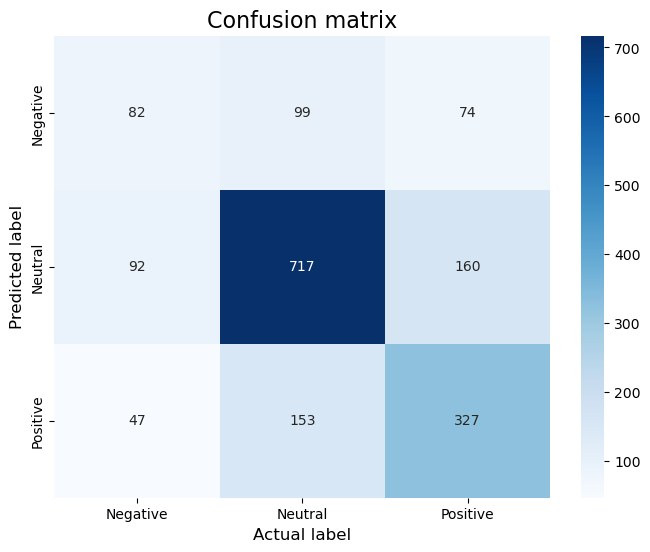

In [22]:
# check model's performance on testing data
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test) 

In [23]:
# save model
model.save('model_LSTM.h5') 